In [1]:
import torch
import numpy as np
import sys; sys.path.append('../src/'); sys.path.append('..')
import matplotlib.pyplot as plt

In [2]:
from src.model.utils.metrics import l2_loss, explained_reconstruction, mean_correlation, importance_correlation, main_exprec
from src.least_volume_image import DCDiscriminator, TrueSNDCGenerator, TrueSNDCGeneratorSig, AutoEncoder, DynamicPruningAE_v2, \
    DynamicPruningAE_BCEv2, DynamicPruningAE_BCEO, DynamicPruningAE_v3, L1AE_BCE, DCGeneratorSig, Adam, read_configs, VolumeAE_BCE, BCEAutoencoder
from src.dataset.images import MNISTImages, CIFAR10Images, ImageToyDataset
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from math import sqrt

In [316]:
dataset = ImageToyDataset('../data/synthetic/images_30k.npy', size=(32, 32), device='cuda:5')

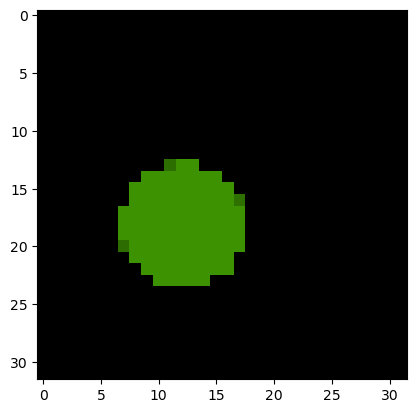

In [322]:
plt.imshow(dataset[6].permute(1,2,0).cpu().numpy())

In [402]:
# path = '../saves/image/syn/l1_0.0003/'
# configs = read_configs('syn_l1', src=path)
# ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
# ae.load(path + 'syn_l1399.tar')

path = '../saves/image/syn/vol_0.001_e1.0/'
configs = read_configs('syn_vol', src=path)
ae = VolumeAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
ae.load(path + 'syn_vol399.tar')

# configs = read_configs('mnist_20', src='../src/')
# ae = DynamicPruningAE_v3(configs, DCDiscriminator, TrueSNDCGenerator, Adam).to('cuda:5')
# ae.load('../saves/image/mnist/dp_1e-04/dp_mnist20000.tar')
ae.eval()

VolumeAE_BCE(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): Linear(in_features=1024, out_fea

<BarContainer object of 50 artists>

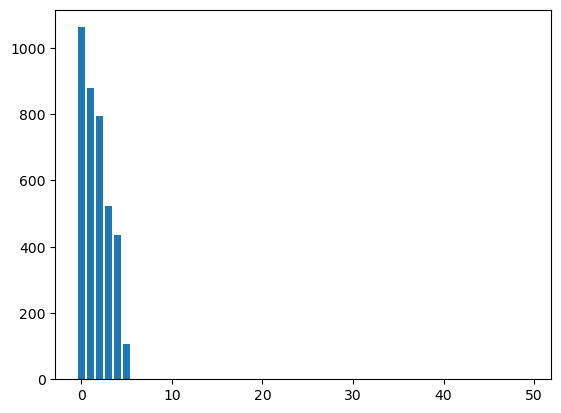

In [403]:
with torch.no_grad():
    z_tr = ae.encode(dataset[:])
    std, idx = z_tr.std(0).sort()
    mean = z_tr.mean(0)[idx]
    ss = std.flip(0).cpu()
plt.bar(range(len(ss)), ss)

In [404]:
with torch.no_grad():
    rec = ae.decode(ae.encode(dataset[:]))
    print(l2_loss(rec, dataset[:]))

tensor(0.5537, device='cuda:5')


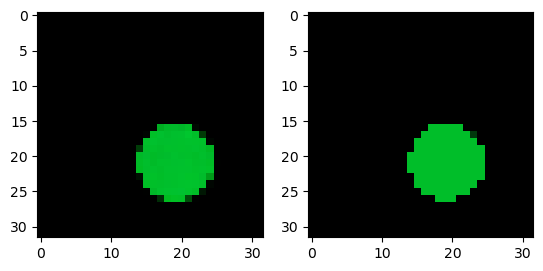

In [405]:
i = 601
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[i].permute(2,1,0).detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(dataset[i].permute(2,1,0).detach().cpu())

In [406]:
l2s = []; vr = []

for d in range(1, 50): 
    with torch.no_grad():
        z = ae.encode(dataset[:])
        z_ = z.clone()
        z_[:, idx[-d]] = mean[-d]
    
        rect_p = ae.decode(z_)
        l2s.append(l2_loss(rect_p, dataset[:]).cpu().numpy())
        vr.append((z - z_).norm(2, dim=1).var().cpu().numpy())

0.9552952207726618

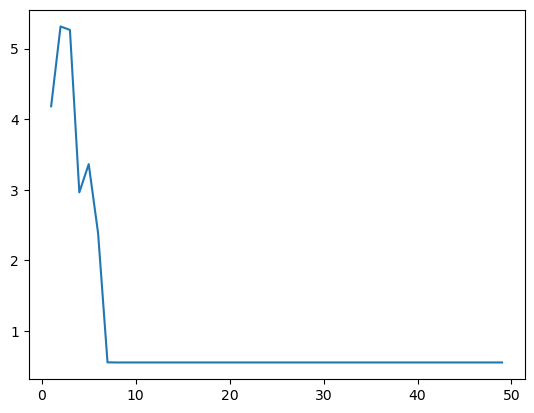

In [407]:
plt.plot(np.arange(1, 50), np.asarray(l2s))
np.corrcoef(np.asarray(l2s[:30]), ss[:len(l2s)][:30])[1, 0]

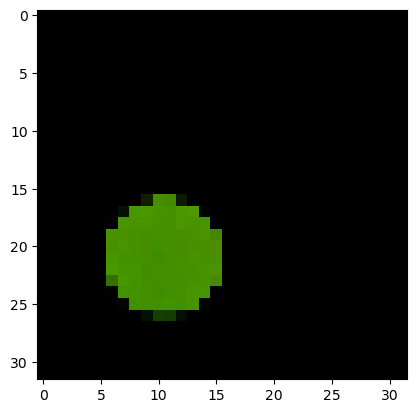

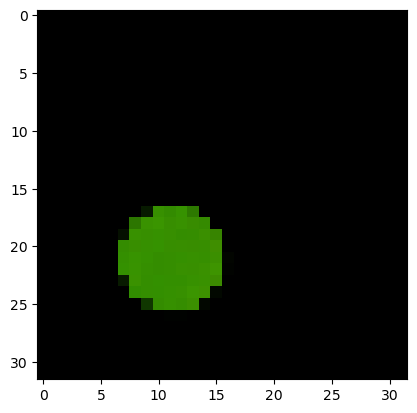

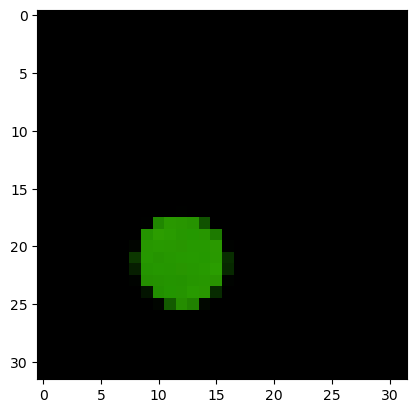

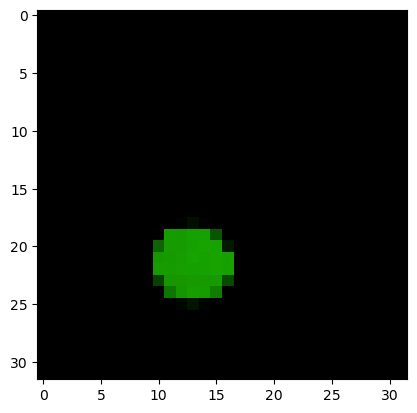

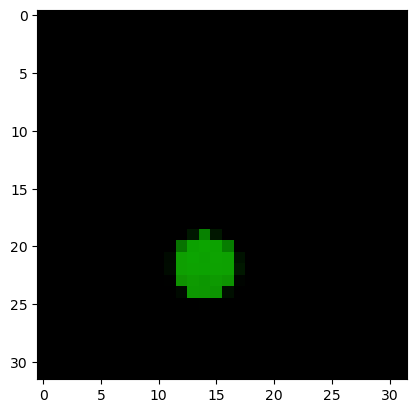

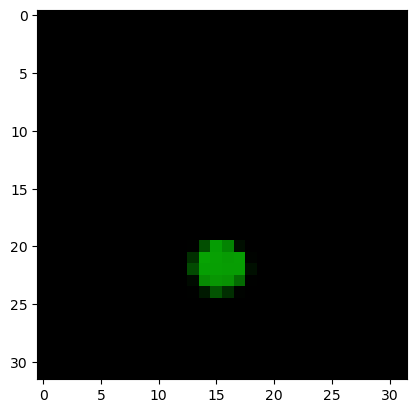

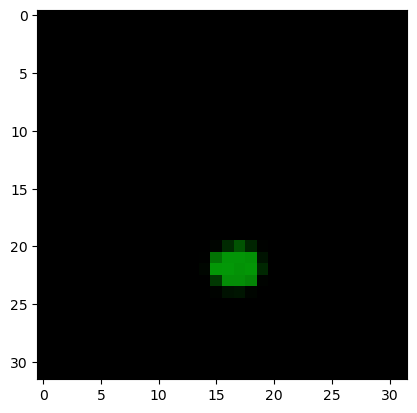

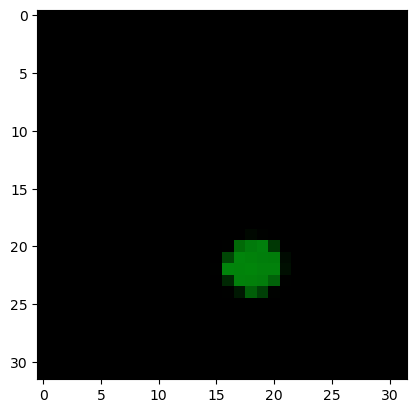

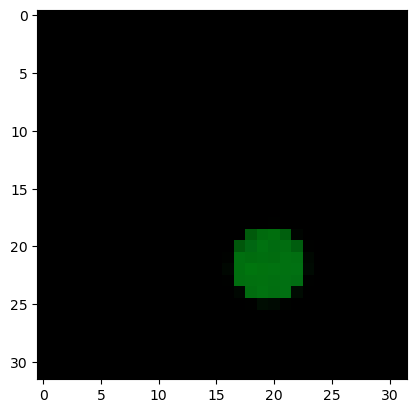

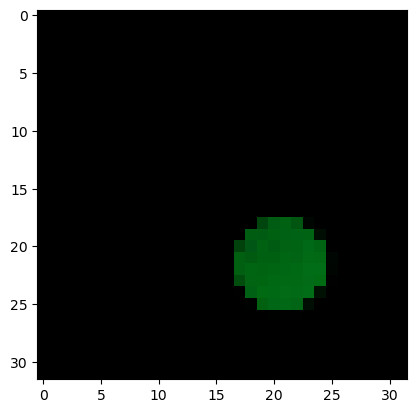

In [412]:
i = 4002; j = 700
for ff in np.linspace(0, 1, 10):
    z_m = (ae.encode(dataset[[i, j]]) * torch.as_tensor([ff, 1-ff], dtype=torch.float).reshape(2, 1).to('cuda:5')).sum(0, keepdim=True)
    plt.imshow(ae.decode(z_m)[0].permute(2,1,0).detach().cpu())
    plt.show()

# MNIST

In [194]:
mnist_train = next(iter(DataLoader(MNISTImages(True, device='cuda:5'), batch_size=60000)))
mnist_test = next(iter(DataLoader(MNISTImages(False, device='cuda:5'), batch_size=10000)))

In [305]:
# path = '../saves/image/mnist/vol/vol_0.003_e1.0/'
# configs = read_configs('mnist_vol', src=path)
# ae = VolumeAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
# ae.load(path + 'vol_mnist399.tar')

path = '../saves/image/mnist/lasso/lasso_0.01/'
configs = read_configs('mnist', src=path)
ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
ae.load(path + 'mnist399.tar')

# path = '../saves/image/mnist/l1/l1_0.003/'
# configs = read_configs('mnist_l1', src=path)
# ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
# ae.load(path + 'l1_mnist399.tar')


ae.eval()

L1AE_BCE(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): Linear(in_features=1024, out_feature

<BarContainer object of 128 artists>

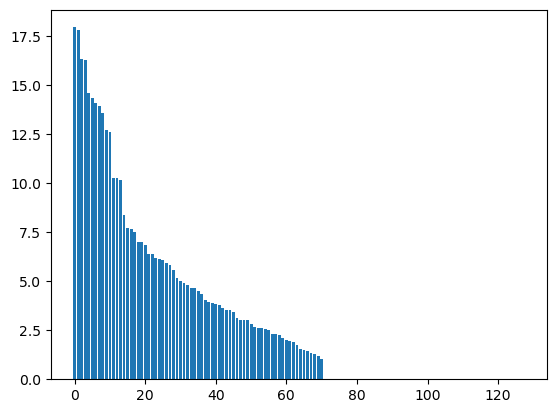

In [306]:
with torch.no_grad():
    z_tr = ae.encode(mnist_train)
    std, idx = z_tr.std(0).sort()
    mean = z_tr.mean(0)[idx]
    ss = std.flip(0).cpu()
plt.bar(range(len(ss)), ss)

In [307]:
l2s = []; vr = []

for d in range(1, 128): 
    with torch.no_grad():
        z = ae.encode(mnist_test)
        z_ = z.clone()
        z_[:, idx[-d]] = mean[-d]
    
        rect_p = ae.decode(z_)
        l2s.append(l2_loss(rect_p, mnist_test).cpu().numpy())
        vr.append((z - z_).norm(2, dim=1).var().cpu().numpy())
l2s = np.asarray(l2s) 

0.9687608508695535

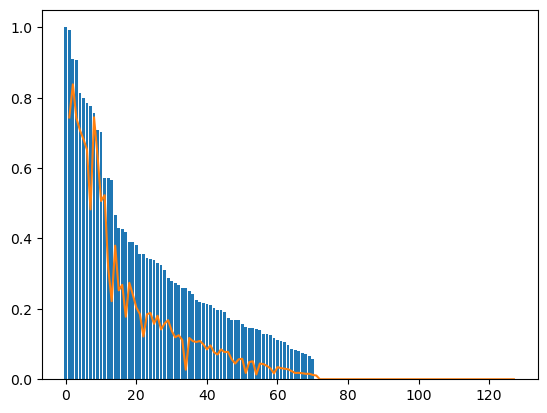

In [308]:
plt.plot(np.arange(1, 128), l2s - l2s.min(), c='tab:orange')
plt.bar(range(len(ss)), ss / ss.max()) 
np.corrcoef(np.asarray(l2s[:30]), ss[:len(l2s)][:30])[1, 0]

In [309]:
with torch.no_grad():
    rec = ae.decode(ae.encode(mnist_train))
    print(l2_loss(rec, mnist_train))

tensor(1.3447, device='cuda:5')


In [310]:
mse_loss(rec, mnist_train)

tensor(0.0018, device='cuda:5')

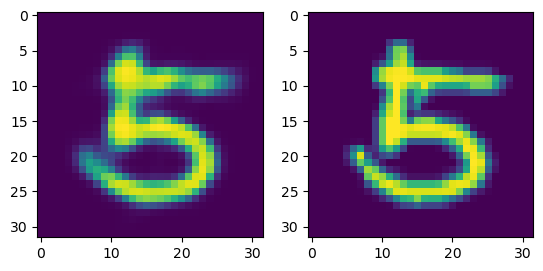

In [311]:
i = 10008
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[i, 0].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mnist_train[i, 0].detach().cpu())

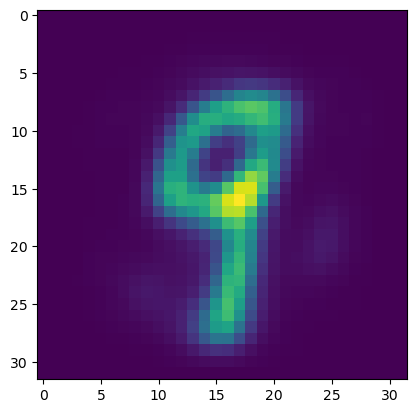

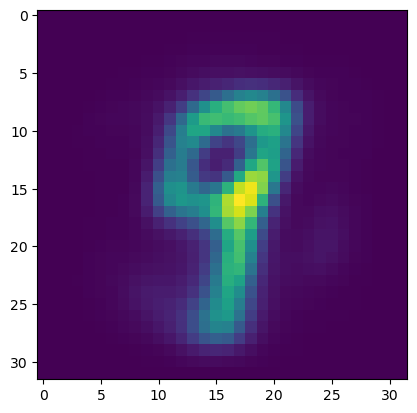

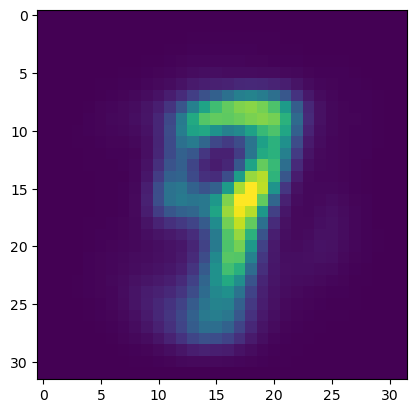

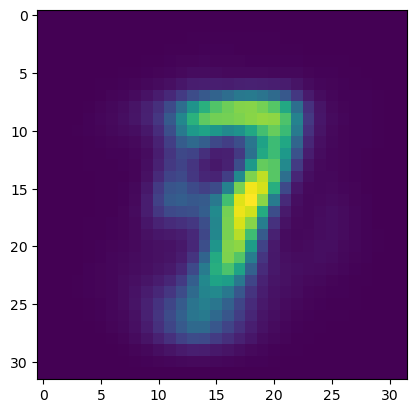

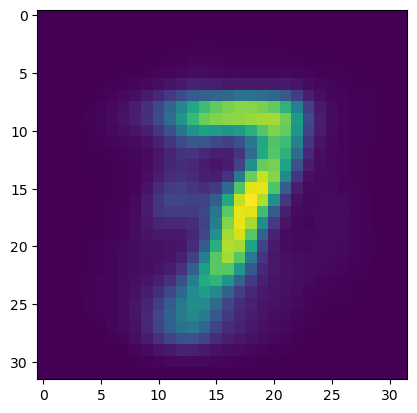

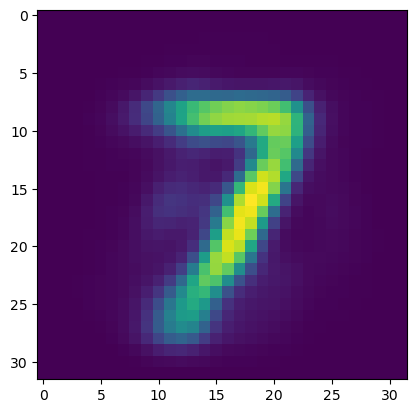

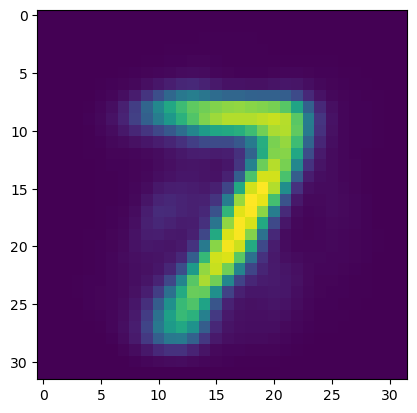

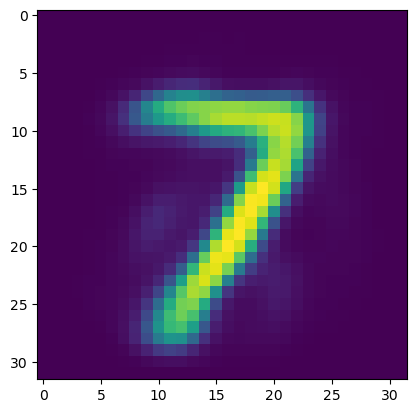

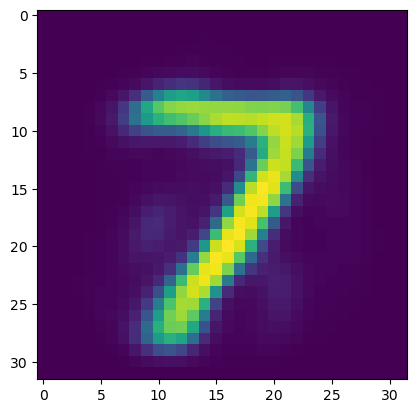

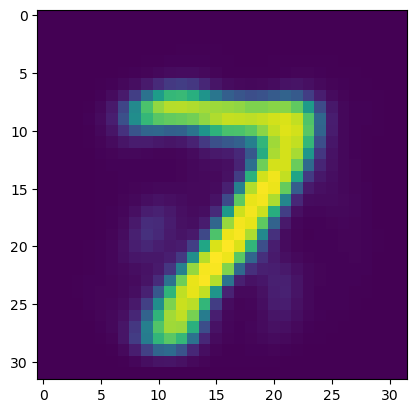

In [304]:
i = 4000; j = 900
for ff in np.linspace(0, 1, 10):
    z_m = (ae.encode(mnist_train[[i, j]]) * torch.as_tensor([ff, 1-ff], dtype=torch.float).reshape(2, 1).to('cuda:5')).sum(0, keepdim=True)
    plt.imshow(ae.decode(z_m)[0, 0].detach().cpu())
    plt.show()

In [63]:
with torch.no_grad():
    rect = ae.decode(ae.encode(mnist_test))
    print(l2_loss(rect, mnist_test))

tensor(0.8131, device='cuda:6')


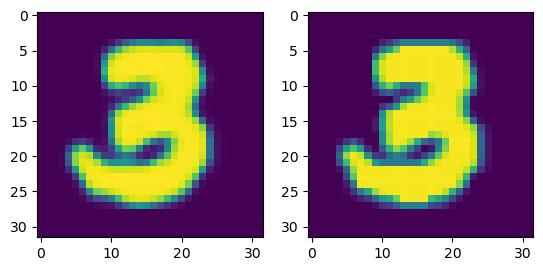

In [64]:
i = 200
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect[i, 0].clip(0, 1).detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mnist_test[i, 0].detach().cpu())

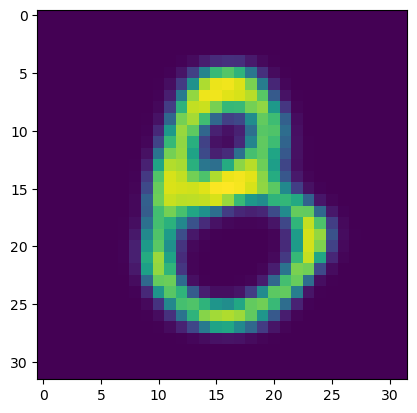

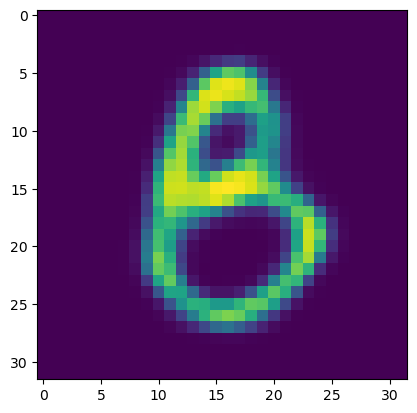

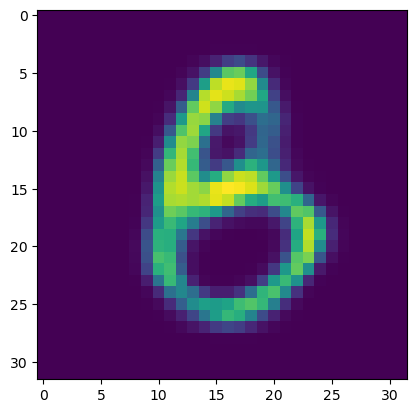

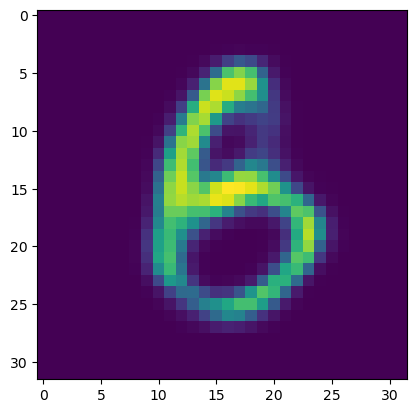

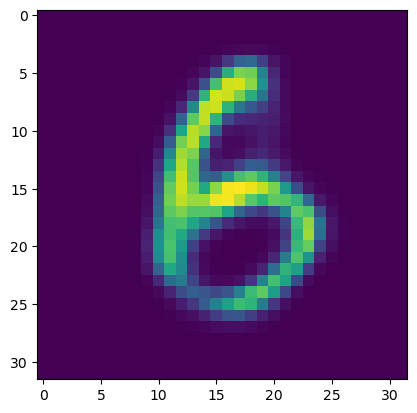

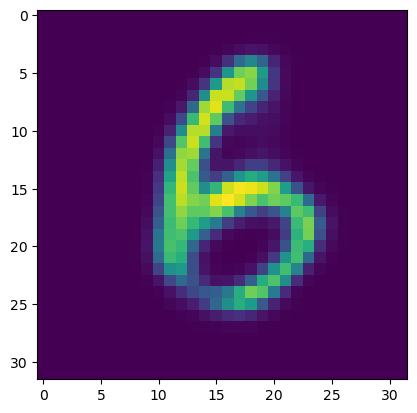

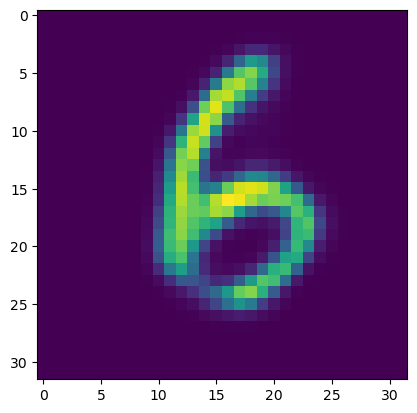

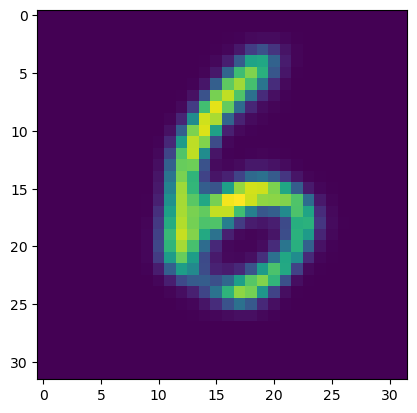

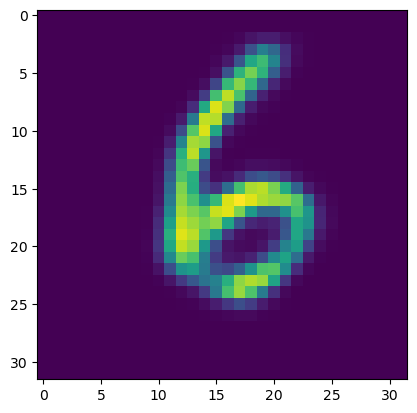

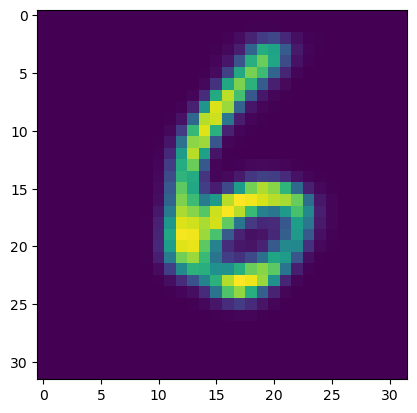

In [62]:
i = 2000; j = 800
for ff in np.linspace(0, 1, 10):
    z_m = (ae.encode(mnist_test[[i, j]]) * torch.as_tensor([ff, 1-ff], dtype=torch.float).reshape(2, 1).to('cuda:6')).sum(0, keepdim=True)
    plt.imshow(ae.decode(z_m)[0, 0].detach().cpu())
    plt.show()

# CIFAR10

In [3]:
cifar_train = torch.as_tensor(CIFAR10Images(True).images.data).to('cuda:5') / 255
cifar_test = torch.as_tensor(CIFAR10Images(False).images.data).to('cuda:5') / 255

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# path = '../saves/image/cifar10/bce_non_0.0/'
# configs = read_configs('cifar10', src=path)
# ae = AutoEncoder(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
# ae.load(path + 'non_cifar10999.tar')

# path = '../saves/image/cifar10/l1std/l1_0.01/'
# configs = read_configs('cifar10_l1', src=path)
# ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
# ae.load(path + 'l1_cifar10999.tar')

# path = '../saves/image/cifar10/lasso/lasso_0.01/'
# configs = read_configs('cifar10', src=path)
# ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
# ae.load(path + 'cifar10999.tar')

path = '../saves/image/cifar10/vol/vol_0.01_e1.0/'
configs = read_configs('cifar10_vol', src=path)
ae = VolumeAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:5')
ae.load(path + 'vol_cifar10999.tar')

ae.eval()

VolumeAE_BCE(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): Linear(in_features=4096, ou

In [6]:
with torch.no_grad():
    rec = ae.decode(ae.encode(cifar_train.permute(0, 3, 2, 1))).permute(0, 3, 2, 1)
    print(l2_loss(rec, cifar_train))

tensor(1.4054, device='cuda:5')


<BarContainer object of 2048 artists>

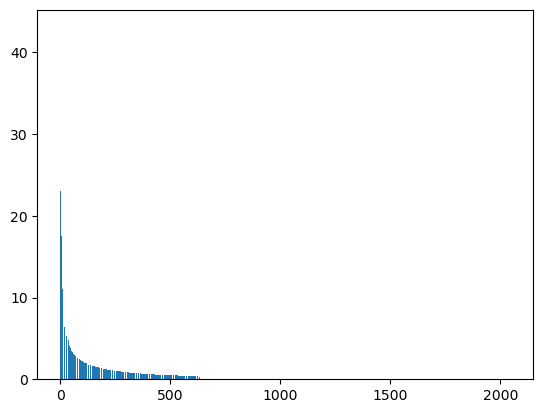

In [7]:
with torch.no_grad():
    z_tr = ae.encode(cifar_train.permute(0, 3, 2, 1))
    std, idx = z_tr.std(0).sort()
    mean = z_tr.mean(0)[idx]
    ss = std.flip(0).cpu()
plt.bar(range(len(ss)), ss)

<BarContainer object of 1548 artists>

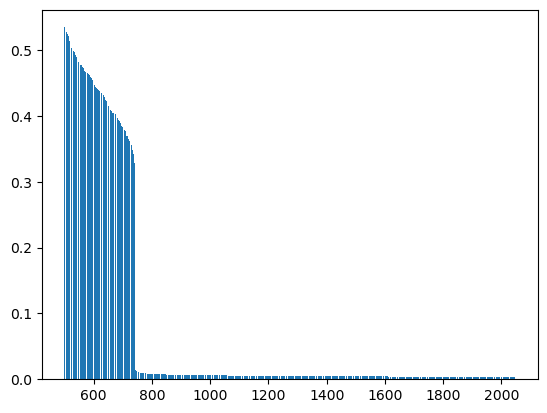

In [186]:
plt.bar(range(len(ss))[500:], ss[500:])

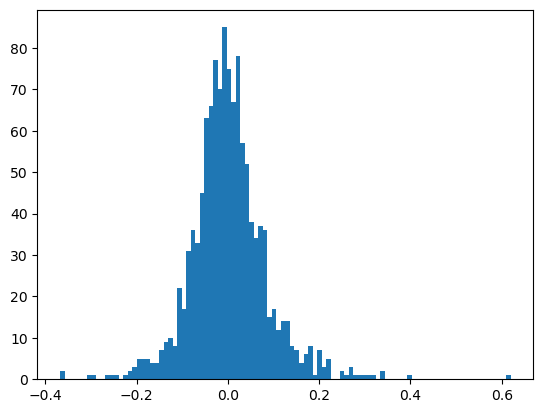

In [172]:
corr = z_tr[:, idx[-50:]].T.corrcoef().triu(1).flatten().cpu().numpy()
plt.hist(corr[corr != 0], bins=100)
plt.show()

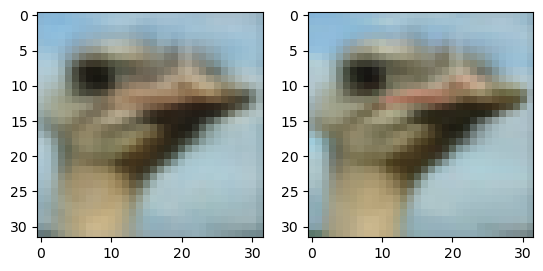

In [18]:
i=30007
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_train[i].detach().cpu())

In [188]:
dd = 1400
with torch.no_grad():
    z = ae.encode(cifar_train.permute(0, 3, 2, 1))
    # z[:, idx[:-600]] = mean[:-600]
    z[:, idx[:-300]] = mean[:-300]
    rec_p = ae.decode(z).permute(0, 3, 2, 1)
    print(l2_loss(rec_p, cifar_train))

tensor(2.6188, device='cuda:5')


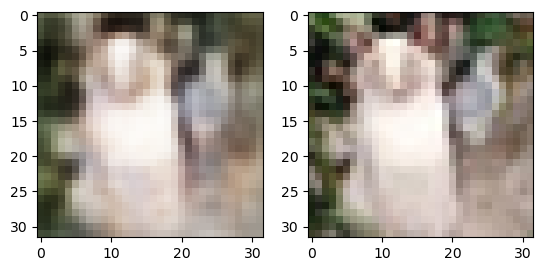

In [189]:
i=5601
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec_p[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_train[i].detach().cpu())

In [190]:
with torch.no_grad():
    rect = ae.decode(ae.encode(cifar_test.permute(0, 3, 2, 1))).permute(0, 3, 2, 1)
    t_rec = l2_loss(rect, cifar_test)
    print(t_rec)

tensor(1.2249, device='cuda:5')


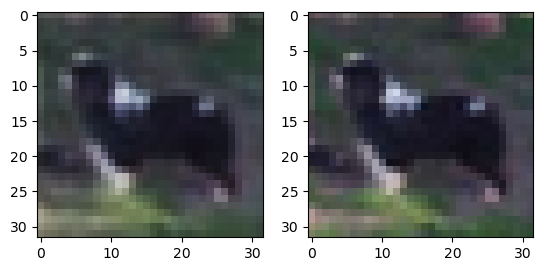

In [191]:
i = 1042
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_test[i].detach().cpu())

In [192]:
l2s = []; vr = []

for d in range(1, 300): 
    with torch.no_grad():
        z = ae.encode(cifar_test.permute(0, 3, 2, 1))
        z_ = z.clone()
        z_[:, idx[-d]] = mean[-d]
    
        rect_p = ae.decode(z_).permute(0, 3, 2, 1)
        l2s.append(l2_loss(rect_p, cifar_test).cpu().numpy())
        vr.append((z - z_).norm(2, dim=1).var().cpu().numpy())

0.9879971690779322


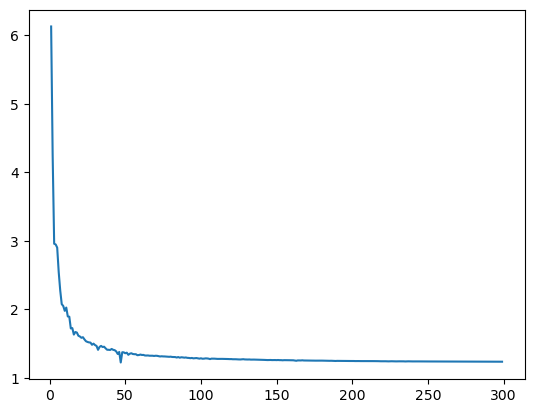

In [193]:
print(np.corrcoef(np.asarray(l2s), ss[:299])[1, 0])
plt.plot(np.arange(1, 300), np.asarray(l2s))
# plt.plot(np.arange(1, 300), ss[:299])
# plt.plot(np.arange(1, 300), np.sqrt(ss[:299] ** 2 - np.asarray(vr)))
# plt.ylim(0, 6)

In [180]:
with torch.no_grad():
    z = ae.encode(cifar_test.permute(0, 3, 2, 1))
    z[:, idx[:-400]] = mean[:-400]
    rect_p = ae.decode(z).permute(0, 3, 2, 1)
    print(l2_loss(rect_p, cifar_test).cpu().numpy())

2.1695657


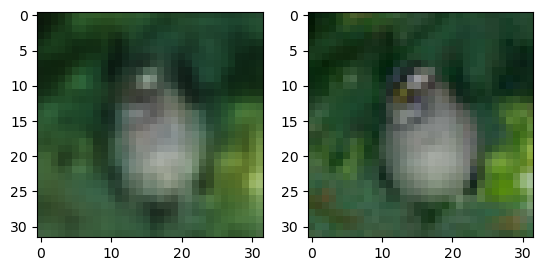

In [181]:
i = 900
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect_p[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_test[i].detach().cpu())